In [1]:
import pandas as pd
import numpy as np
current_state = np.random.get_state()
np.random.set_state(current_state)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


from scipy import stats
from scipy.stats import ttest_ind
import time 
import random

from collections import Counter
from sklearn import ensemble
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, precision_recall_curve, mean_squared_error, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn import svm
from sklearn import metrics
from IPython.display import display
from sklearn.metrics import recall_score

from datetime import datetime
import plotly  as py
py.tools.set_credentials_file(username='mcmanusdatascience', api_key='Mkw1SmxGJj1HPglRqBES')
import plotly.graph_objs as go
import plotly.tools as tls


import warnings
warnings.filterwarnings("ignore")

import pandas_datareader.data as web
import datetime as dt
from datetime import date
import re
from sklearn import preprocessing
import scipy.stats  as stats

In [2]:
#load data
ATVI = pd.read_csv(r'C:\Users\Sean\Documents\Thinkful\Video Game Stocks Data\csv\ATVI.csv')
ATVI_VIEWS = pd.read_csv(r'C:\Users\Sean\Documents\Thinkful\Video Game Stocks Data\csv\ATVI_views.csv')

#load synced data

atvi_sync_stock = pd.read_csv(r'C:\Users\Sean\Documents\Thinkful\Video Game Stocks Data\csv\ATVI_td.csv')
atvi_sync_views = pd.read_csv(r'C:\Users\Sean\Documents\Thinkful\Video Game Stocks Data\csv\ATVI_views_7daymean_td.csv')

In [3]:
#changing index and date to both dataframes
atvi_sync_stock.Date = pd.to_datetime(atvi_sync_stock.Date)

#add date data for views
atvi_sync_views['Date'] = atvi_sync_stock.Date
#set index
atvi_sync_views.index = atvi_sync_stock.Date
atvi_sync_stock.index = atvi_sync_stock.Date

Before we dive in, as we're trying to explore the relationship between the stock price movement and the viewing data let's do some simple correlations with lagging data.

In [4]:
##### append data to each row for the past average and peak
atvi_sync_views['past_average_1'] = atvi_sync_views['7day_averages'].shift(1,axis=0)
atvi_sync_views['past_average_2'] = atvi_sync_views['7day_averages'].shift(2,axis=0)
atvi_sync_views['past_average_3'] = atvi_sync_views['7day_averages'].shift(3,axis=0)
atvi_sync_views['past_average_4'] = atvi_sync_views['7day_averages'].shift(4,axis=0)
atvi_sync_views['past_average_5'] = atvi_sync_views['7day_averages'].shift(5,axis=0)
atvi_sync_views['past_average_10'] = atvi_sync_views['7day_averages'].shift(10,axis=0)
##### append data to each row for the past peak and peak
atvi_sync_views['past_peak_1'] = atvi_sync_views['7day_peaks'].shift(1,axis=0)
atvi_sync_views['past_peak_2'] = atvi_sync_views['7day_peaks'].shift(2,axis=0)
atvi_sync_views['past_peak_3'] = atvi_sync_views['7day_peaks'].shift(3,axis=0)
atvi_sync_views['past_peak_4'] = atvi_sync_views['7day_peaks'].shift(4,axis=0)
atvi_sync_views['past_peak_5'] = atvi_sync_views['7day_peaks'].shift(5,axis=0)
atvi_sync_views['past_peak_10'] = atvi_sync_views['7day_peaks'].shift(10,axis=0)

#make master dataframe
atvi_master = pd.concat([atvi_sync_stock,atvi_sync_views], axis=1, join_axes=[atvi_sync_stock.index])

# make master dataframe that removes the first 10 dates for initial exploration.
#we'll keep the other master dataframe for further feature generation

atvi_master_2015_10_07 = atvi_master.loc['2015-10-07':]


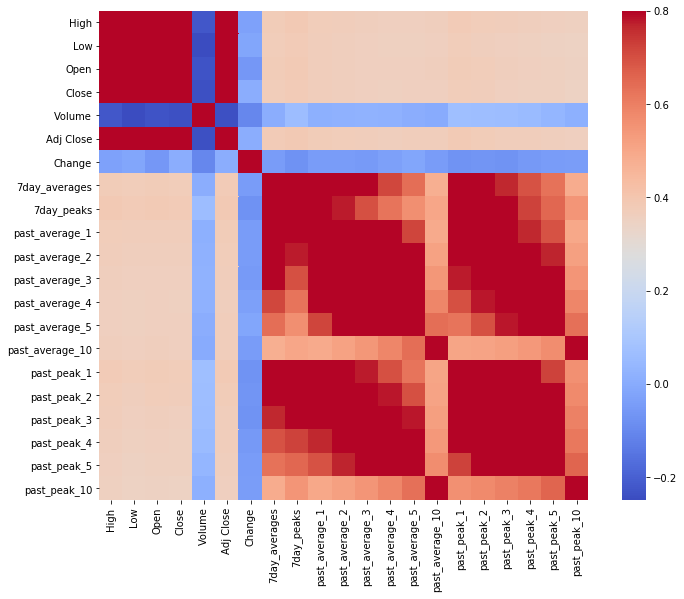

Close              1.000000
Adj Close          0.999850
Low                0.999146
High               0.998907
Open               0.997670
7day_peaks         0.379660
past_peak_1        0.372930
7day_averages      0.371984
past_average_1     0.367119
past_peak_2        0.366367
past_average_2     0.362585
past_peak_3        0.360259
past_average_10    0.359828
past_average_3     0.358874
past_average_5     0.358384
past_average_4     0.357649
past_peak_4        0.356253
past_peak_5        0.354385
past_peak_10       0.349227
Change             0.008397
Volume            -0.238304
Name: Close, dtype: float64


In [5]:
# Make the correlation matrix.
corrmatrix = atvi_master_2015_10_07.corr()

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmatrix, vmax=.8, square=True, cmap='coolwarm')
plt.show()

print(corrmatrix['Close'].sort_values(ascending= False))

There's a definite correlation between the current and past averages and the current day close. There seems to be about a a lag between the values based on the trend for pearson's correlation. Let's investigate the p-values to make sure this is significant.

In [6]:
from scipy.stats import pearsonr
stats.pearsonr(atvi_master_2015_10_07['7day_averages'],atvi_master_2015_10_07.Close)


(0.3719841922765563, 4.340853001541793e-32)

The result is highly significant. There's a definete correlation here and given that we're looking at a 7 day window this can already be used to predict price. With some more complicated feature engineering a model this could provide huge utility in a multi-variate time series model.

In order to generate our time series features let's used the ATVI_MASTER dataframe at the end, we can clean this thing up completely to account for missing data that will result from the data generation process.

We will start with the features listed below. They have previously been used in simple 
supervised learning models to predict next day directional movement [1]:

<img src="variables.jpg">

## Reference

1. https://arxiv.org/abs/1605.00003

# Relative Strength Index(RSI)

The Relative Strength Index (RSI), developed by J. Welles Wilder, is a momentum oscillator that measures the speed and change of price movements. The RSI oscillates between zero and 100. 
Traditionally the RSI is considered overbought when above 70 and oversold when below 30.

We will calculate RSI for both the stock price and for the average views on Twitch.

In [7]:
#recall we have two dataframes we're working off of:
# the atvi_master dataframe has missing data due the generation of data that requires past input
# the atvi_master_2015_10_07 does not have missing data. For now we will work with the maser dataframe and clean the data at the end
#MAKE RSI VARIABLE
#make loss and gain columns based on change
atvi_master['gain'] = atvi_master.Change [atvi_master.Change > 0] 
atvi_master['loss'] = atvi_master.Change [atvi_master.Change < 0]

#setup window for calculating RSI
window = 14

#enter 0 values so these are appropriately counted
atvi_master['gain'] = atvi_master['gain'].fillna(0)
atvi_master['loss'] = atvi_master['loss'].fillna(0)

#fix loss column

atvi_master['loss'] = -atvi_master['loss'] 

#calculate number of gains/loss in last 14 days

atvi_master['rsmeanloss_14 days'] = atvi_master['loss'].rolling(window, min_periods=1).mean()

atvi_master['rsmeangain_14 days'] = atvi_master['gain'].rolling(window, min_periods=1).mean()

#create RS

atvi_master['rs'] = atvi_master['rsmeangain_14 days']/atvi_master['rsmeanloss_14 days']

#create RSI

atvi_master['rsi'] = 100 - 100/(1+atvi_master['rs'])

# Stociastic Oscillator

The stochastic oscillator variable is a momentum indicator that uses support and resistance levels. Fundamentally, the use of the stochiastic oscillator is to predict price turning points by comparing the closing price of a security to its price range. The calculation of stochiastic oscillator finds the range between an asset’s high and low price during a given period of time. The current price is then expressed as a percentage of this range with 0% indicating the bottom of the range and 100% indicating the upper limits of the range over the time period covered. This gives a global view of the price in that window - typically price movement patterns are predicted when the oscillator tends towards 0% or 100%. This prediction is of course subject to a number of assumptions.

In [8]:
#Make Stochastic Oscillator variable

atvi_master['14daylowestlow'] = atvi_master['Low'].rolling(window).min()
atvi_master['14dayhighesthigh'] = atvi_master['High'].rolling(window).max()

atvi_master['so'] = 100 * (atvi_master['Close'] - atvi_master['14daylowestlow'])/(atvi_master['14dayhighesthigh'] - atvi_master['14daylowestlow'])

# William's R%
Williams %R, or just %R, is a technical analysis oscillator showing the current closing price in relation to the high and low of the past N days (for a given N). It was developed by a publisher and promoter of trading materials, Larry Williams. Its purpose is to tell whether a stock or commodity market is trading near the high or the low, or somewhere in between, of its recent trading range.

In [9]:
#make williams R%

atvi_master['williams_R']= (atvi_master['14dayhighesthigh']-atvi_master['Close'])/(atvi_master['14dayhighesthigh'] - atvi_master['14daylowestlow']) * -100

# Rate of Change

he Rate-of-Change (ROC) indicator,  also referred to as simply Momentum, is a pure momentum oscillator that measures the percent change in price from one period to the next. 

In [10]:
#calculate price rate of change
roc= []
for i in range(len(atvi_master['Close'])):
    roc.append((atvi_master['Close'].iloc[i]-atvi_master['Close'].iloc[i-14])/(atvi_master['Close'].iloc[i-14]))
    
atvi_master['roc'] = roc
# enter 0 for first 14
atvi_master['roc'].iloc[0:14] = 0

In [11]:
# calculate rolling rate of change for view averages and peaks
roc= []
for i in range(len(atvi_master['7day_averages'])):
    roc.append((atvi_master['7day_averages'].iloc[i]-atvi_master['7day_averages'].iloc[i-14])/(atvi_master['7day_averages'].iloc[i-14]))

atvi_master['rolling_average_roc'] = roc
# enter 0 for first 14
atvi_master['rolling_average_roc'].iloc[0:14] = 0

# Exponential Moving Average
The exponential moving average (EMA) is a weighted moving average (WMA) that gives more weighting, or importance, to recent price data than the simple moving average (SMA) does. The EMA responds more quickly to recent price changes than the SMA.

In [12]:
#write function to generate moving average data
def ema(data, period=0, column='<CLOSE>'):
    data['ema' + str(period)] = data[column].ewm(ignore_na=False, min_periods=period, com=period, adjust=True).mean()
    
    return data

ema(atvi_master, period=10, column='Close')
ema(atvi_master, period=14, column='Close')
ema(atvi_master, period=26, column='Close')
ema(atvi_master, period=12, column='Close')

,Date,High,Low,Open,Close,Volume,Adj Close,Change,market_open,market_close,...,14daylowestlow,14dayhighesthigh,so,williams_R,roc,rolling_average_roc,ema10,ema14,ema26,ema12
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-23,2015-09-23,31.690001,31.000000,31.330000,31.620001,7788000,30.766861,0.290001,2015-09-23 13:30:00+00:00,2015-09-23 20:00:00+00:00,...,NaN,NaN,NaN,NaN,-0.303217,-0.430194,NaN,NaN,NaN,NaN
2015-09-24,2015-09-24,31.700001,30.969999,31.360001,31.490000,9845100,30.640368,0.129999,2015-09-24 13:30:00+00:00,2015-09-24 20:00:00+00:00,...,NaN,NaN,NaN,NaN,-0.315584,-0.466102,NaN,NaN,NaN,NaN
2015-09-25,2015-09-25,32.500000,31.590000,31.709999,32.060001,12107900,31.194992,0.350002,2015-09-25 13:30:00+00:00,2015-09-25 20:00:00+00:00,...,NaN,NaN,NaN,NaN,-0.313490,-0.453420,NaN,NaN,NaN,NaN
2015-09-28,2015-09-28,32.450001,31.200001,32.220001,31.309999,12049300,30.465225,-0.910002,2015-09-28 13:30:00+00:00,2015-09-28 20:00:00+00:00,...,NaN,NaN,NaN,NaN,-0.305611,-0.507088,NaN,NaN,NaN,NaN
2015-09-29,2015-09-29,31.270000,30.309999,31.250000,30.660000,11385200,29.832764,-0.590000,2015-09-29 13:30:00+00:00,2015-09-29 20:00:00+00:00,...,NaN,NaN,NaN,NaN,-0.334202,-0.482350,NaN,NaN,NaN,NaN
2015-09-30,2015-09-30,31.240000,30.430000,31.010000,30.889999,9411500,30.056557,-0.120001,2015-09-30 13:30:00+00:00,2015-09-30 20:00:00+00:00,...,NaN,NaN,NaN,NaN,-0.322885,-0.466921,NaN,NaN,NaN,NaN
2015-10-01,2015-10-01,31.459999,30.620001,31.389999,30.900000,8515700,30.066286,-0.490000,2015-10-01 13:30:00+00:00,2015-10-01 20:00:00+00:00,...,NaN,NaN,NaN,NaN,-0.314400,-0.472160,NaN,NaN,NaN,NaN
2015-10-02,2015-10-02,31.459999,30.250000,30.570000,31.459999,9430200,30.611176,0.889999,2015-10-02 13:30:00+00:00,2015-10-02 20:00:00+00:00,...,NaN,NaN,NaN,NaN,-0.312650,-0.475444,NaN,NaN,NaN,NaN
2015-10-05,2015-10-05,32.060001,31.549999,31.820000,31.969999,8559100,31.107418,0.150000,2015-10-05 13:30:00+00:00,2015-10-05 20:00:00+00:00,...,NaN,NaN,NaN,NaN,-0.294728,-0.461313,NaN,NaN,NaN,NaN


# Moving Average Convergence Divergence

MACD, short for moving average convergence/divergence, is a trading indicator used in technical analysis of stock prices, created by Gerald Appel in the late 1970s.

The MACD indicator depends on three time parameters, namely the time constants of the three EMAs used in it's calculation. The notation "MACD(a,b,c)" usually denotes the indicator where the MACD series is the difference of EMAs with characteristic times a and b, and the average series is an EMA of the MACD series with characteristic time c. These parameters are usually measured in days. The most commonly used values are 12, 26, and 9 days, that is, MACD(12,26,9). As true with most of the technical indicators, MACD also finds its period settings from the old days when technical analysis used to be mainly based on the daily charts. The reason was the lack of the modern trading platforms which show the changing prices every moment. As the working week used to be 6-days, the period settings of (12, 26, 9) represent 2 weeks, 1 month and one and a half week.

Since the MACD is based on moving averages, it is inherently a lagging indicator. As a metric of price trends, the MACD is less useful for stocks that are not trending (trading in a range) or are trading with erratic price action.

In [13]:
#moving average convergence divergence

def macd(data, period_long=26, period_short=12, period_signal=9, column='<CLOSE>'):
    remove_cols = []
    if not 'ema' + str(period_long) in data.columns:
        data = ema(data, period_long)
        remove_cols.append('ema' + str(period_long))

    if not 'ema' + str(period_short) in data.columns:
        data = ema(data, period_short)
        remove_cols.append('ema' + str(period_short))

    data['macd_val'] = data['ema' + str(period_short)] - data['ema' + str(period_long)]
    data['macd_signal_line'] = data['macd_val'].ewm(ignore_na=False, min_periods=0, com=period_signal, adjust=True).mean()

    data = data.drop(remove_cols, axis=1)
        
    return data

macd(atvi_master, period_long=26, period_short=12, period_signal=9, column='Close')

,Date,High,Low,Open,Close,Volume,Adj Close,Change,market_open,market_close,...,so,williams_R,roc,rolling_average_roc,ema10,ema14,ema26,ema12,macd_val,macd_signal_line
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-23,2015-09-23,31.690001,31.000000,31.330000,31.620001,7788000,30.766861,0.290001,2015-09-23 13:30:00+00:00,2015-09-23 20:00:00+00:00,...,NaN,NaN,-0.303217,-0.430194,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-24,2015-09-24,31.700001,30.969999,31.360001,31.490000,9845100,30.640368,0.129999,2015-09-24 13:30:00+00:00,2015-09-24 20:00:00+00:00,...,NaN,NaN,-0.315584,-0.466102,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-25,2015-09-25,32.500000,31.590000,31.709999,32.060001,12107900,31.194992,0.350002,2015-09-25 13:30:00+00:00,2015-09-25 20:00:00+00:00,...,NaN,NaN,-0.313490,-0.453420,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-28,2015-09-28,32.450001,31.200001,32.220001,31.309999,12049300,30.465225,-0.910002,2015-09-28 13:30:00+00:00,2015-09-28 20:00:00+00:00,...,NaN,NaN,-0.305611,-0.507088,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-29,2015-09-29,31.270000,30.309999,31.250000,30.660000,11385200,29.832764,-0.590000,2015-09-29 13:30:00+00:00,2015-09-29 20:00:00+00:00,...,NaN,NaN,-0.334202,-0.482350,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-30,2015-09-30,31.240000,30.430000,31.010000,30.889999,9411500,30.056557,-0.120001,2015-09-30 13:30:00+00:00,2015-09-30 20:00:00+00:00,...,NaN,NaN,-0.322885,-0.466921,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-01,2015-10-01,31.459999,30.620001,31.389999,30.900000,8515700,30.066286,-0.490000,2015-10-01 13:30:00+00:00,2015-10-01 20:00:00+00:00,...,NaN,NaN,-0.314400,-0.472160,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-02,2015-10-02,31.459999,30.250000,30.570000,31.459999,9430200,30.611176,0.889999,2015-10-02 13:30:00+00:00,2015-10-02 20:00:00+00:00,...,NaN,NaN,-0.312650,-0.475444,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-05,2015-10-05,32.060001,31.549999,31.820000,31.969999,8559100,31.107418,0.150000,2015-10-05 13:30:00+00:00,2015-10-05 20:00:00+00:00,...,NaN,NaN,-0.294728,-0.461313,NaN,NaN,NaN,NaN,NaN,NaN


# On Balance Volume
On-balance volume (OBV) is a technical analysis indicator intended to relate price and volume in the stock market. OBV is based on a cumulative total volume

In [14]:
#on balance volume:
# need to reset index and do some quick housekeeping to make this work, we can change it back afterwards
atvi_master = atvi_master.drop('Date', axis=1)
atvi_master.date = pd.to_datetime(atvi_master.date)
atvi_master.index = range(0,946)

def on_balance_volume(data, trend_periods=14, close_col='<CLOSE>', vol_col='<VOL>'):
    for index, row in data.iterrows():
        if index > 0:
            last_obv = data.loc[index - 1, 'obv']
            if row[close_col] > data.at[index - 1, close_col]:
                current_obv = last_obv + row[vol_col]
            elif row[close_col] < data.at[index - 1, close_col]:
                current_obv = last_obv - row[vol_col]
            else:
                current_obv = last_obv
        else:
            last_obv = 0
            current_obv = row[vol_col]

        data.set_value(index, 'obv', current_obv)

    data['obv_ema' + str(trend_periods)] = data['obv'].ewm(ignore_na=False, min_periods=0, com=trend_periods, adjust=True).mean()
    
    return data
#calculate obv
on_balance_volume(atvi_master, close_col='Close', vol_col='Volume')
atvi_master.index = atvi_master.date

<h1><center> Outcome variables </center></h1>
Our outcomes of interest in this study will be % change from open (we may code this as a categorical variable later pending the results of our data exploration) and direction of change from open (coded as increase=1, decrease=0).

In [15]:
#1=stock goes up from open to close 0=stock goes down from open to close
atvi_master['samedaydirectionchange']=atvi_master['Close']>atvi_master['Open']
atvi_master['samedaypercentagechangefromopen'] = atvi_master['Close']/atvi_master['Open'] - 1

In [16]:
#let's take a look at the distribution of the percentage change data
print(atvi_master["samedaypercentagechangefromopen"].describe())

print('60% percentile = ' + str(np.percentile(atvi_master["samedaypercentagechangefromopen"],60)))

count    946.000000
mean       0.000120
std        0.018057
min       -0.086275
25%       -0.008777
50%        0.000547
75%        0.010255
max        0.074063
Name: samedaypercentagechangefromopen, dtype: float64
60% percentile = 0.0037461964673701775


[Text(0.5, 0, 'Percentage change from open')]

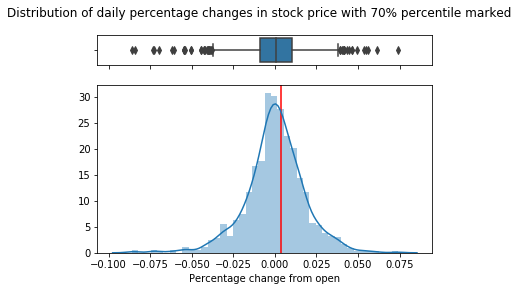

In [17]:
#explore percentage change data

# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
f.suptitle('Distribution of daily percentage changes in stock price with 70% percentile marked')  
# Add a graph in each part
plt.axvline(0.00375, 0,30, label='60% percentile', color='r')
sns.boxplot(atvi_master["samedaypercentagechangefromopen"], ax=ax_box)
sns.distplot(atvi_master["samedaypercentagechangefromopen"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_hist.set(xlabel='Percentage change from open')

In [18]:
#60% percentile looks like a nice cut off point it's not overly ambitious
# if we can pick these days in the top 60% or so of days of gains, we would be doing well.
atvi_master['samedaychangeabove70percentile']=atvi_master['samedaypercentagechangefromopen']>0.00374

In [19]:
#since we're trying to predict what will happen the next trading day, we need to adjust our variables accordingly

atvi_master['nextdaydirectionchange'] = atvi_master['samedaydirectionchange'].shift(-1,axis=0)

atvi_master['nextdaypercentagechange'] = atvi_master['samedaypercentagechangefromopen'].shift(-1,axis=0)

atvi_master['nextdaychangeabove70percentile']=atvi_master['samedaychangeabove70percentile'].shift(-1, axis=0)

atvi_master['3daydirectionchange']=atvi_master['Close'].shift(-3,axis=0)>atvi_master['Open']

atvi_master['5daydirectionchange']=atvi_master['Close'].shift(-5,axis=0)>atvi_master['Open']
atvi_master['10daydirectionchange']=atvi_master['Close'].shift(-10,axis=0)>atvi_master['Open']
atvi_master['15daydirectionchange']=atvi_master['Close'].shift(-15,axis=0)>atvi_master['Open']
atvi_master['20daydirectionchange']=atvi_master['Close'].shift(-20,axis=0)>atvi_master['Open']

atvi_master['nextdayclose']=atvi_master['Close'].shift(-1,axis=0)
atvi_master['3dayclose']=atvi_master['Close'].shift(-3,axis=0)
atvi_master['5dayclose']=atvi_master['Close'].shift(-5,axis=0)

In [20]:
#date data is missing, need to fix this before exporting

atvi_master['Date'] = atvi_master.index


In [21]:
#need to get rid of last 5 variables which are all false for 5 day direction change and first 26 which are all false for macd
atvi_master_final = atvi_master.loc['2015-10-28':'2019-06-19']

In [22]:
atvi_master_final.to_csv(r'C:\Users\Sean\Documents\Thinkful\Video Game Stocks Data\csv\atvi_master_final_2.csv', index = None, header=True)